# 线性回归 Linear regression

>公式1：线性回归模型预测 Linear Regression model prediction
$$
    \hat{y}=\theta_{0}+\theta_{1} x_{1}+\theta_{2} x_{2}+\cdots+\theta_{n} x_{n}
$$

>公式2：线性回归模型预测（向量化形式）Linear Regression model prediction (vectorized form)
$$
    \hat{y}=h_\theta(x)=\theta·x
$$

训练模型就是设置模型参数直到模型最拟合训练集过程 

在实践中，将`均方误差MSE`最小化比最小化`均方根误差RMSE`更为简单，二者效果相同。

>公式3： 均方根误差Root Mean Square Error (RMSE):
$$
\operatorname{RMSE}(\mathbf{X}, h_\theta)=\sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(\theta^Tx^{(i)}-y^{(i)}\right)^{2}}
$$

>公式4： 均方误差Mean Square Error (MSE):
$$
\operatorname{MSE}(\mathbf{X}, h_\theta)={\frac{1}{m} \sum_{i=1}^{m}\left(\theta^Tx^{(i)}-y^{(i)}\right)^{2}}
$$

本章将介绍两种不同的训练模型的方法：
1. 通过闭式方程，直接计算出最拟合训练集的参数模型。【1.1】
2. 使用迭代优化的方法，(既梯度下降)逐渐调整模型参数直至训练集上的成本函数调至最低，最终趋同于第一种方法计算出来的模型参数。【1.3】

## 标准方程 Normal Equation

- 利用闭式解方法计算

    为了得到使成本函数最小值的θ。有一个闭式解方法：`标准方程`

>公式5：标准方程 Normal Equation
$$
    \hat{θ}=(X^TX)^{-1}X^Ty
$$

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def normalEquation(X,y):
    theta = np.linalg.inv(X.T@X)@X.T@y
    return theta

1. 首先随机生成线性数据集  **$y=4+3x+$高斯噪音**

In [3]:
X = np.array(np.random.rand(100, 1)*2)           # rand()是0-1的均匀随机分布
y = np.array(4 + 3*X + np.random.randn(100, 1))  # randn()是均值为0方差为1的标准正态分布 -> 生成高斯噪音

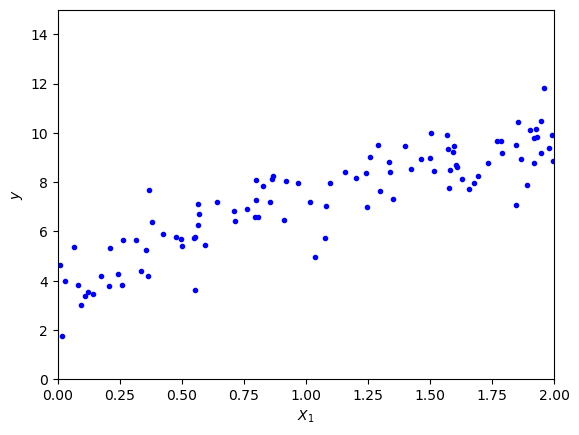

In [4]:
# sns.set(style="darkgrid")

plt.plot(X, y, 'b.')

plt.xlabel("$X_1$")
plt.ylabel("$y$")
plt.axis([0.00, 02.00, 0 ,15])

plt.show()

2. 使用`正规方程`计算 $\hat{θ}$

    在第一列前面添加新的一列，使得特征矩阵满足以向量化的解决方法,假设$x_{0}=1$

In [5]:
X_tr = np.c_[np.ones((100,1)), X]
X_tr[:5]

array([[1.        , 1.69490739],
       [1.        , 1.932533  ],
       [1.        , 0.25735925],
       [1.        , 0.56909993],
       [1.        , 1.630215  ]])

In [6]:
theta = normalEquation(X_tr, y)
theta

array([[4.19902998],
       [2.91863871]])

你们期待的是$\theta_0=4$,$\theta_1=3$.实际得到的值非常接近，由于噪声的存在，不可能完全还原成原来的函数。

3. 使用$\hat{θ}$进行预测

In [7]:
x = np.linspace(X.min(), X.max(),100)      # 表示横坐标
f = theta[0][0] * 1 + (theta[1][0] * x)    # 表示预测值

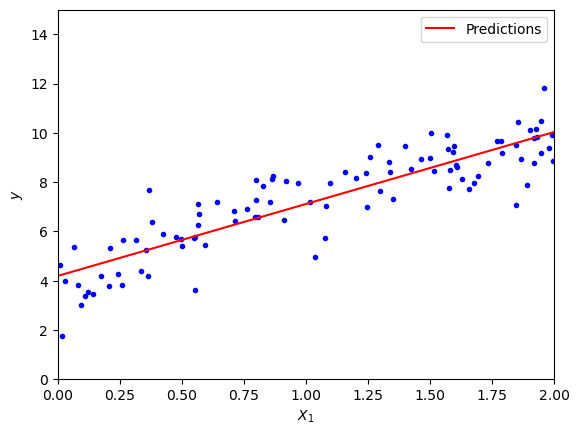

In [8]:
plt.plot(X, y, 'b.')
plt.plot(x, f, 'r', label="Predictions")

plt.xlabel("$X_1$")
plt.ylabel("$y$")
plt.axis([0.00, 02.00, 0 ,15])
plt.legend()

plt.show()

- `Scikit-Learn`的`LinerRegression`实现基于`SVD`线性回归

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
lin_model = LinearRegression()
lin_model.fit(X, y)
# intercept_ coef_ 指偏差项和特征权重
lin_model.intercept_, lin_model.coef_

(array([4.19902998]), array([[2.91863871]]))

In [11]:
lin_model.predict([[0], [2]])

array([[ 4.19902998],
       [10.03630739]])

- `scipy.linalg.lstsq()`函数

    `LinerRegression`是基于`scipy.linalg.lstsq()`函数(最小二乘)

In [12]:
theta_svd, residuals, rank, s = np.linalg.lstsq(X_tr, y, rcond=1e-6)
theta_svd

array([[4.19902998],
       [2.91863871]])

此函数是计算$\hat{θ}=X^+y$,其中$X^+$是$X$的伪逆

In [13]:
# 计算伪逆
np.linalg.pinv(X_tr)@y

array([[4.19902998],
       [2.91863871]])

`伪逆`本身是使用被称为`非奇异分解SVD`的标准矩阵分解技术来计算的，可以将训练集矩阵X分解为$UΣV^T$的乘积。
`伪逆`比计算`标准方程`更加有效，再加上它可以很好的处理边缘的情况:矩阵是奇异的情况下，伪逆总有定义。

## 计算复杂度 Computational Complexity

`标准方程`需要计算${{\left( {{X}^{T}}X \right)}^{-1}}$，如果特征数量$n$较大则运算代价大，因为矩阵逆的计算时间复杂度为$O(n^3)$.
`Scikit-Learn`的`LinerRegression`类使用`SVD`方法的时间复杂度为$O(n^2)$

通常来说当$n<10000$时还是可以接受的，只适用于线性模型，不适合逻辑回归模型等其他模型。

# 梯度下降 Gradient Descent

- 在梯度下降的描述中，模型参数被随机初始化并反复调整，使成本函数最小化。学习步长和成本函数的斜率成正比，因此，当参数接近最小值，步长逐渐变小。

<img src="../images/other/4-1.png" width="400">

- 梯度下降中一个注意重要参数就是每一步的步长，这取决于超参数`学习率`，如果学习率太低，算法需要经过大量的迭代才能收敛,这将耗费很长的时间。

<img src="../images/other/4-2.png" width="400">

- 如果学习率过高，会导致算法发散，值越来越大，最后无法找到好的解决方案。

<img src="../images/other/4-3.png" width="400">

- 如下图`梯度下降陷阱`所示，如果随机初始化是否从左侧起步，那么会收敛到一个局部最小值，而不是全局最小值；如果从右侧起步，那么需要经过很长时间才能越过整片高原；如果你停下的太早，就永远达不到全局最小值。

<img src="../images/other/4-4.png" width="400">

- 而线性回归模型的MSE成本函数，恰好是个凸函数不存在局部最小值，只有一个全局最小值。应用梯度下降时，需要保证所有特征只的大小比例都差不多，比如使用`数据标准化`，否则收敛时间会长很多。

<img src="../images/other/4-5.png" width="400">

公式6：成本函数的偏导数 Partial derivatives of the cost function
>$$
\frac{\partial}{\partial \theta_{j}} \operatorname{MSE}(\boldsymbol{\theta})=\frac{2}{m} \sum_{i=1}^{m}\left(\boldsymbol{\theta}^{} x^{(i)}-y^{(i)}\right) x_{j}^{(i)}
$$

公式7：成本函数的梯度向量Gradient vector of the cost function
>$$
\nabla_{\boldsymbol{\theta}} \operatorname{MSE}(\boldsymbol{\theta})=\left(
\begin{array}{l}
\frac{\partial}{\partial \theta_{0}} \operatorname{MSE}(\boldsymbol{\theta}) \\
\frac{\partial}{\partial \theta_{1}} \operatorname{MSE}(\boldsymbol{\theta}) \\
\vdots \\
\frac{\partial}{\partial \theta_{n}} \operatorname{MSE}(\boldsymbol{\theta})
\end{array}
\right)=\frac{2}{m} \mathbf{X}^{T}(\mathbf{X} \boldsymbol{\theta}-\mathbf{y})
$$

## 批量梯度下降 Batch Gradient Descent

- 在计算`批量梯度下降`的每一步时，都是使用整批的训练数据。因此，面对极为庞大的数据集时，算法会变得很缓慢。
- 如果要训练的线性模型，拥有几十万个特征，使用梯度下降比`标准方程`或`SVD`要快得多。

公式8：梯度下降步骤Gradient Descent step 
>$$
\theta^{(next\ step)}:=\theta−η\nabla_{\boldsymbol{\theta}} \operatorname{MSE}(\boldsymbol{\theta})\\
$$

In [14]:
Rate = 0.1  # 学习率
n = 1000    # 迭代次数
m = X_tr.shape[0]

theta = np.random.randn(2,1)   # 随机初始θ

In [15]:
# 批量梯度下降的快速实现
for i in range(n):
    gradients = (2/m) * X_tr.T @ (X_tr@theta - y)
    theta = theta - Rate*gradients

In [16]:
theta

array([[4.19902998],
       [2.91863871]])

下图展示了各种学习率下的梯度下降。

<img src="../images/other/4-6.png" width="600">

1. 找到合适的学习率可以使用`网格搜索`，但是需要限制迭代次数，这可以淘汰掉那些收敛耗时太长的模型。
2. 限制迭代次数的方法：在开始就设置一个非常大的迭代次数，但是当梯度向量的值变得很微小时中断算法。

## 随机梯度下降 Stochastic Gradient Descent

<img src="../images/other/4-7.png" width="300">

1. 与`BGD`相比，使用`SGD`，每一个训练步骤要快的多，但也更加随机。
2. 当成本函数非常不规则时,如`梯度下降陷阱`。`SGD`其实可以帮助算法跳出`局部最小值`，所以相较`BGD`，它对找到`全局最小值`更有优势。 
3. 缺点是永远定位不到最小值，要解决这个问题，有一个办法是逐步减少学习率：开始的时候步长比较大(有助于快速进展和逃离局部最小值)，然后越来越小，让算法尽量的靠近`全局最小值`，这个过程叫做`模拟退火simulated annealing`。

- 学习率调度实现`SGD`

In [17]:
epochs = 50               # 迭代次数  
t0, t1 = 5, 50            # 学习率参数
m = X_tr.shape[0]         # 100

theta = np.random.randn(2,1)   # 随机初始θ

In [18]:
def learning_schedule(t):   # 学习率调度
    return t0 / (t + t1)

<img src="../images/other/4-8.png" width="400">

In [19]:
for epoch in range(epochs):   # 一次完整的训练数据一轮称为epoch
    for i in range(m):
        # 每一步在训练集中随机选择一个实例
        random_index = np.random.randint(m)
        x_i = X_tr[random_index : random_index+1]    # [1,...] 
        y_i = y[random_index : random_index+1]
        
        # 计算梯度
        gradients = (2) * x_i.T @ (x_i@theta - y_i)
        
        # 学习率
        Rate = learning_schedule(epoch * m + i)
        
        # 梯度下降
        theta = theta - Rate * gradients

In [20]:
theta   # 遍历50次 效果优于BGD1000次迭代

array([[4.18612109],
       [2.92557278]])

- `SGD`的前20个步骤：

<img src="../images/other/4-9.png" width="400">

1.  由于实例是随机选取的，因此，某些实例可能每个轮次被选取几次，而其他实例则可能根本不被选中。
2. 使用随机梯度下降时，训练实例必须`独立且均匀分布/独立同分布/IID`,以确保平均而言将参数拉向全局最优解，方法是在训练过程中对实例进行随机混洗，但收敛速度较慢。

-  `Scikit-Learn`的`SGDRegressor`实现`SGD`线性回归

In [21]:
from sklearn.linear_model import SGDRegressor

In [22]:
sgd_model = SGDRegressor(
    max_iter=1000,  # 最大迭代次数
    tol=1e-3,  # 迭代终止误差限
    penalty=None,  # 要使用的惩罚 (None:不使用任何正则化)
    eta0=0.1  # 初始学习率
)

In [23]:
sgd_model.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [24]:
sgd_model.intercept_, sgd_model.coef_

(array([4.22504959]), array([2.97345394]))

## 小批量梯度下降 Mini-batch Gradient Descent

1. 不同于`BGD`和`SGD`:在每一步根据完整的训练集，或仅基于一个实例来计算，`MBGD`是在称为小型批量的随机实例集上计算梯度。
2. 主要优点是：可以通过矩阵操作的硬件优化来提高性能。与`SGD`相比，该算法在参数空间上进行更加稳定，尤其是相当大的小批次中，但他很难摆脱`局部最小值`。

In [25]:
epochs = 50         # 迭代次数  
MB_size = 20        # 批次样本总数
t0, t1 = 200, 1000  # 学习率参数
m = X_tr.shape[0]   # 100

theta = np.random.randn(2,1)   # 随机初始θ

In [26]:
def learning_schedule(t):   # 学习率调度
    return t0 / (t + t1)

t = 0

<img src="../images/other/4-10.png" width="400">

In [27]:
for epoch in range(epochs):
    # 数据混洗
    shuffled_index = np.random.permutation(m)
    X_tr_shuffled = X_tr[shuffled_index]
    y_shffled = y[shuffled_index]

    for i in range(0, m, MB_size):  # 步长为MB_size
        t += 1
        # 每一步在小批量随机实例集中选择一个实例
        x_i = X_tr_shuffled[i:i + MB_size]  # [1,...]
        y_i = y_shffled[i:i + MB_size]

        # 计算梯度
        gradients = (2 / MB_size) * x_i.T @ (x_i @ theta - y_i)

        # 学习率
        Rate = learning_schedule(t)

        # 梯度下降
        theta = theta - Rate * gradients

In [28]:
theta

array([[4.17144605],
       [2.8469322 ]])

## 线性回归算法的比较

- 参数空间中梯度下降路径

<img src="../images/other/4-13.png" width="400">

- 线性回归算法的比较

<img src="../images/other/4-11.png" >

# 多项式回归 Polynomial Regression

1. 首先，生成一个基于二次方程式的非线性和噪音数据集.  **$y=0.5x^2+x+2+$高斯噪音**

In [29]:
np.random.seed(42)

In [30]:
X = np.array(6 * np.random.rand(100,1) - 3)
y = np.array(0.5 * X**2 + X + 2 + np.random.randn(100,1))

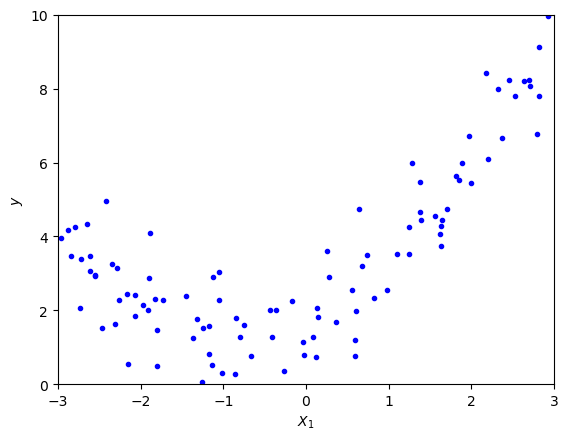

In [31]:
plt.plot(X,y,'b.')
plt.xlabel("$X_1$")
plt.ylabel("$y$")
plt.axis([-3, 3, 0 ,10])
plt.show()

2. `Scikit-Learn`的`PolynomialFeatures`实现进行特征的构造
    
    如果样本量多，回归问题很复杂，而原始特征只有$x_1,x_2$可以用多项式创建更多的特征$x_1、x_2、x_1x_2、x_1^2、x_2^2、... x_1^nx_2^n$。
    
    `PolynomialFeatures(degree=d)`可以将一个包含$n$个特征的数组转化为包含$\frac{(n+d)!}{d!n!}$个特征的数组。

$$
\small
\text { mapFeature }(x)=\left[\begin{array}{c}
1 \\
x_{1} \\
x_{2} \\
x_{1}^{2} \\
x_{1} x_{2} \\
x_{2}^{2} \\
x_{1}^{3} \\
\vdots \\
x_{1} x_{2}^{5} \\
x_{2}^{6}
\end{array}\right]
$$

In [32]:
from sklearn.preprocessing import PolynomialFeatures

In [33]:
poly_features = PolynomialFeatures(degree=2,           # 控制多项式的次数
                                   include_bias=False  # 是否要设置 0 次幂那一列
                                  )

In [34]:
X_poly = poly_features.fit_transform(X)

`X_poly`包含着`X`的原始特征以及该特征的平方

In [35]:
X[0],X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

3. `Scikit-Learn`的`LinerRegression`实现`SVD`线性回归

In [36]:
lin_poly_model = LinearRegression()
lin_poly_model.fit(X_poly, y)
lin_poly_model.intercept_, lin_poly_model.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

模型估算$\hat{y}=0.56x^2+0.93x+1.78$, 而实际函数为$y=0.5x^2+x+2+$高斯噪音

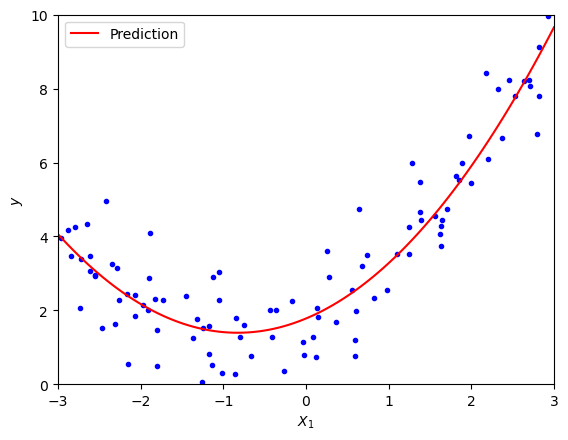

In [37]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)    # x
X_new_poly = poly_features.fit_transform(X_new)    # x^1 , x^2 
y_pred = lin_poly_model.predict(X_new_poly)        # θ_1*x^1 + θ_2*x^2 

plt.plot(X,y,'b.')
plt.plot(X_new,y_pred,'r-',label='Prediction')

plt.xlabel("$X_1$")
plt.ylabel("$y$")
plt.axis([-3, 3, 0 ,10])
plt.legend()

plt.show()

# 学习曲线 Learning Curves

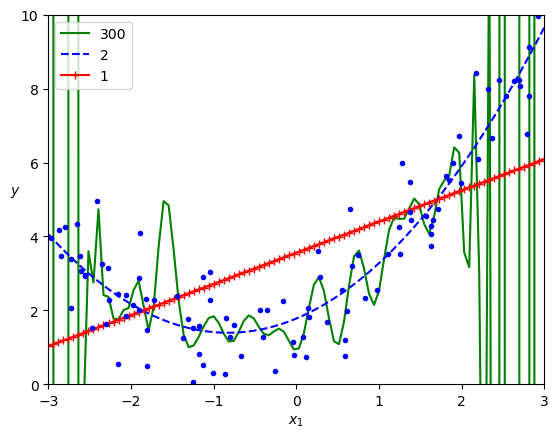

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, degree in (("g-", 300), ("b--", 2), ("r-+", 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_model = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_model),
    ])
    polynomial_regression.fit(X, y)
    y_pred = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_pred, style, label=str(degree))

plt.plot(X, y, "b.")
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.show()

可以观察到， 高阶多项式回归模型严重过拟合训练数据而线性模型则欠拟合，最能泛化的模型是二次模型。
确定模型复杂性的方法:
1. 使用`交叉验证集`估计模型泛化能力
2. 观察`学习曲线`: 曲线绘制的是模型在`训练集`和`验证集`上关于训练集大小(m)的性能函数。

- 绘制1阶线性回归的`学习曲线`

In [39]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='../Fonts/SourceHanSerifSC-Medium.otf', size=12)

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [41]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    train_sise = X_train.shape[0]    # 80
    
    for m in range(1, train_sise):
        # 训练模型
        model.fit(X_train[:m], y_train[:m])
        # 预测训练集和交叉验证集
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        # 计算MSE
        train_errors.append(mean_squared_error(y_true=y_train[:m], y_pred=y_train_pred))
        val_errors.append(mean_squared_error(y_true=y_val, y_pred=y_val_pred))
    
    # 绘制学习曲线 MSE->RMSE
    plt.plot(np.sqrt(train_errors), "r-+", label="训练")
    plt.plot(np.sqrt(val_errors), "b-", label="验证")
    plt.legend(prop=my_font)
    plt.axis([0, 80, 0, 3])
    plt.xlabel("训练集大小", fontproperties=my_font) 
    plt.ylabel("RMSE")
    plt.show()

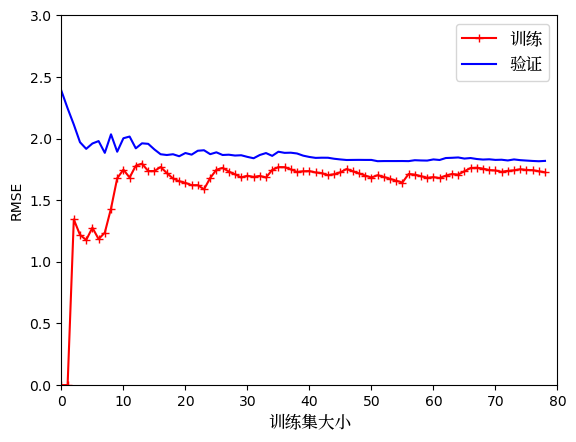

In [42]:
lin_model = LinearRegression()
plot_learning_curves(lin_model, X, y)

上面学习曲线表现为经典的`欠拟合`：都达到了平稳状态，并且很接近并且很高。这种情况下，如果添加更多的训练实例也无济于事，你需要使用更加复杂的模型或提供更好的特征。

- 绘制10阶多项式模型的`学习曲线`

In [43]:
from sklearn.pipeline import Pipeline

In [44]:
Polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_model", LinearRegression())
])

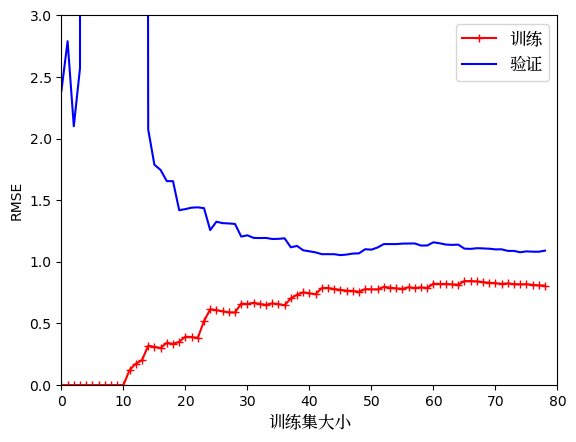

In [45]:
lin_10_degree_model = Polynomial_regression.fit(X,y)
plot_learning_curves(model=lin_10_degree_model, X=X, y=y)

1. 与线性回归模型相比，训练数据上的误差要低很多
2. 曲线之间存在间隙，意味着该模型在训练数据上的性能，要比在验证数据上的性能要好得多，这是`过拟合`的表现，但是如果你选择更大的训练集，两条曲线会继续接近。

# 正则化线性模型 Regularized Linear Models

在前两章，我们提到减少`过拟合`的一个办法是对模型进行`正则化`，他拥有的自由度越小,则`过拟合`的数据难度就越大。
- 正则化多项式模型的一个简单的方法，是减少多项式次数。
- 对于线性模型，通常是通过约束模型的权重解决`多重共线性问题`
    1. `岭回归`
    2. `Lasso回归`
    3. `弹性网络`


## 岭回归 Ridge Regression

`岭回归(Tikhonov 回归)`是线性回归的正则化版本:将正则化项$\alpha  \sum\limits_{j=1}^{n}{\theta _{j}^{2}}$加入到成本函数中。

>公式9：岭回归成本函数  Ridge Regression cost function
$$
J\left( \theta  \right)= MSE(\theta)+ \alpha  \sum\limits_{i=1}^{n}{\theta _{i}^{2}}
$$

偏置项$\theta_0$没有进行正则化。如果我们将${w}$定义为`特征权重的向量`($\theta_1$至$\theta_n$),则正则项等于$\|_ {w} \|_ {2}^{2}$

>公式10：岭回归成本函数的偏导数Partial derivatives of the Ridge Regression cost function
$$
\begin{aligned}
\frac{\partial\left(MSE+\alpha\|\boldsymbol{w}\|_{2}^{2}\right)}{\partial \boldsymbol{w}} &=\frac{\partial\left(\|\boldsymbol{y}-\boldsymbol{X} \boldsymbol{w}\|_{2}^{2}+\alpha\|\boldsymbol{w}\|_{2}^{2}\right)}{\partial \boldsymbol{w}} \\
&=\frac{\partial(\boldsymbol{y}-\boldsymbol{X} \boldsymbol{w})^{T}(\boldsymbol{y}-\boldsymbol{X} \boldsymbol{w})}{\partial \boldsymbol{w}}+\frac{\partial \alpha\|\boldsymbol{w}\|_{2}^{2}}{\partial \boldsymbol{w}}\\
&=0-2 \boldsymbol{X}^{T} \boldsymbol{y}+2 \boldsymbol{X}^{\top} \boldsymbol{X} \boldsymbol{w}+2 \alpha \boldsymbol{w}\\
&=2( \boldsymbol{X}^{T} \boldsymbol{X}+\alpha I) \boldsymbol{w}-2\boldsymbol{X}^{T} \boldsymbol{y}
\end{aligned}\\
\Rightarrow( \boldsymbol{X}^{T} \boldsymbol{X}+\alpha I) \boldsymbol{w}=\boldsymbol{X}^{T} \boldsymbol{y}
$$


现在,只要$( {X}^{T} {X}+\alpha I) $存在逆矩阵,就可以求解出$w$.一个矩阵存在逆矩阵的充分必要条件是这个矩阵的行列式不为0。假设
原本的特征矩阵中存在共线性,则方阵$( {X}^{T} {X}) $就会不满秩(存在全为零的行)

$$
\small
\begin{aligned}
\boldsymbol|{X}^{\top} \boldsymbol{X}+\alpha \boldsymbol{I}\ |=&\left|\begin{array}{ccccc}
a_{11} & a_{12} & a_{13} & \ldots & a_{1 n} \\
0 & a_{22} & a_{23} & \ldots & a_{2 n} \\
0 & 0 & a_{33} & \ldots & a_{3 n} \\
& \ldots & & & \\
0 & 0 & 0 & \ldots & 0
\end{array}\right|+\left|\begin{array}{ccccc}
\alpha & 0 & 0 & \ldots & 0 \\
0 & \alpha & 0 & \ldots & 0 \\
0 & 0 & \alpha & \ldots & 0 \\
& \ldots & & & \\
0 & 0 & 0 & \ldots & \alpha
\end{array}\right| \\
&=\left|\begin{array}{ccccc}
a_{11}+\alpha & a_{12} & a_{13} & \ldots & a_{1 n} \\
0 & a_{22}+\alpha & a_{23} & \ldots & a_{2 n} \\
0 & 0 & a_{33}+\alpha & \ldots & a_{3 n} \\
& & \ldots & & & \\
0 & 0 & 0 & \ldots & \alpha
\end{array}\right|
\end{aligned}
$$

最后得到的这个行列式还是一个梯形行列式,然而它的已经不存 在全0行或者全0列了,除非
1. 等于0
2. 原本的矩阵${X}^{T} {X} $中存在对角线上元素为$-\alpha$,其他元素都为0的行或者列

否则矩阵$( {X}^{T} {X}+\alpha I) $永远都是满秩。

在 `Sklearn`中, $\alpha$的值可以自由控制,因此可以让它不为0,以避免第一种情况。
而第二种情况,如果发现某个 $\alpha$的取值下模型无法求解,那只需要换一个 $\alpha$的取值就好了,也可以顺利避免。

也就是说,矩阵的逆是永远存在的!有了这个保障,${w}$就可以写作:
>公式11：闭式解的岭回归 Ridge Regression closed-form solution
$$
{w}=(X^{T} X+\alpha I)^{-1}X^{T}y
$$

如此,正则化系数$\alpha$就非常爽快地避免了″精确相关关系“带来 的影响,至少最小二乘法在$\alpha$存在的情況下是一定可以使用了。
对于存在”高度相关关系“的矩阵,也可以通过调大$\alpha$,来让
$(X^{T} X+\alpha I)$矩阵的行列式变大,从而让逆矩阵変小,以此控制参 数向量$\boldsymbol{w}$的偏移。当$\alpha$越大,模型越不容易受到共线性的影响

如此,多重共线性就被控制住了:最小二乘法一定有解,并且这个解可以通过$\alpha$来进行调节,以确保不会偏离太多。

与线性回归一样，可以通过计算`闭式方程`或执行`梯度下降`来执行岭回归

1. 首先随机生成线性数据集  **$y=1+0.5x+$高斯噪音**

In [46]:
np.random.seed(42)
m = 20
X = np.array(3 * np.random.rand(m,1))
y = np.array(1 + 0.5*X + np.random.randn(m,1)/1.5)

X_new = np.linspace(0, 3, 100).reshape(100, 1) 

  2. (1)`Scikit-Learn`的`Ridge`实现`岭回归`

In [47]:
from sklearn.linear_model import Ridge

In [48]:
ridge_model = Ridge(alpha=1,                 # 正则化强度
                    solver="cholesky")       # 指定求解方法  
ridge_model.fit(X, y)
ridge_model.predict([[1.5]])

array([[1.55071465]])

In [49]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

- `cholesky`使用标准的scipy.linalg.solve函数来获得闭合形式的解。
- `sag`使用随机平均梯度下降。它也使用迭代过程，并且当`n_samples`和`n_feature`都很大时，通常比其他求解器更快。注意，“sag”快速收敛仅在具有近似相同尺度的特征上被保证。

  2. (2)使用`随机梯度下降`执行执行岭回归

In [50]:
sgd_model_l2 = SGDRegressor(penalty='l2')  # 设置使用的正则项类型，“l2” 表示希望添加一个L2正则项到成本函数中
sgd_model_l2.fit(X, y.ravel())
sgd_model_l2.predict([[1.5]])

array([1.46619232])

- 对比不同的λ值对某些线性数据进行训练的几种岭模型

In [51]:
def plot_model(Regul, polynomial, Rates, **model_kargs):
    for Rate, style in zip(Rates, ("b-", "g--", "r:")):
        # 如果λ=0，岭回归仅是线性回归
        if Rate > 0:
            model = Regul(alpha=Rate, **model_kargs)
        else:
            model = LinearRegression()

        if polynomial:
            model = Pipeline([
                ("poly_features",
                 PolynomialFeatures(degree=10, include_bias=False)),  # 拓展数据
                ("std_scaler", StandardScaler()),  # 进行缩放
                ("regul_reg", model),
            ])

        model.fit(X, y)
        y_regul = model.predict(X_new)

        plt.plot(X_new, y_regul, style, label=r"$\alpha = {}$".format(Rate))

    plt.plot(X, y, "b.")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$")
    plt.axis([0, 3, 0, 4])

    plt.show()

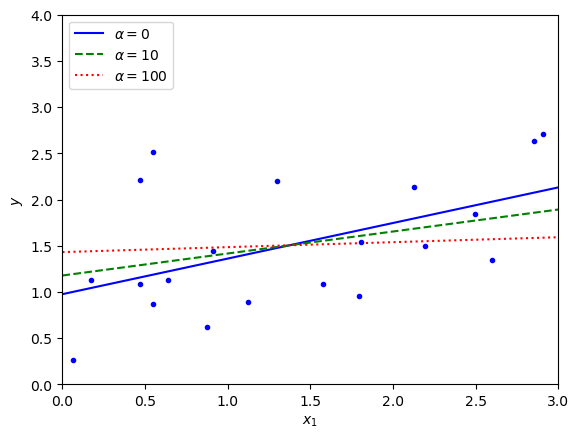

In [52]:
# 线性模型
plot_model(Regul=Ridge, polynomial=False, Rates=(0,10,100), random_state=42)

由于是`普通岭`,所以导致的是线性预测

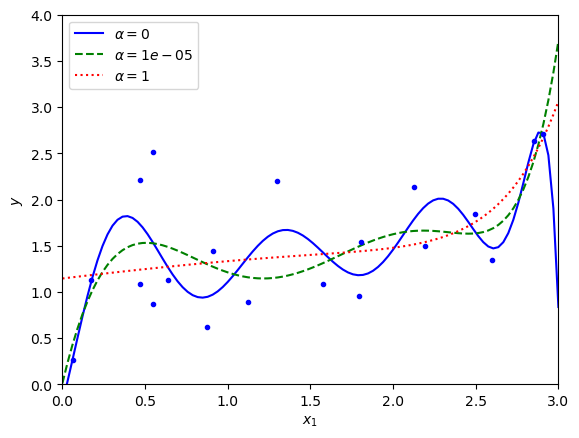

In [53]:
# 多项式模型
plot_model(Regul=Ridge, polynomial=True, Rates=(0,10**-5,1), random_state=42)

由于λ的增加会导致更平坦的预测，从而减少了方差，增加了其偏差

## Lasso 回归 Lasso Regression

`最小绝对收缩和选择算子回归(Least Absolute Shrinkage and Selection Operator Regression)`:不同于`岭回归`,`Lasso回归`是将正则化项权重向量的$ ℓ_1$范数$\|_ {w} \|_ {1}$加入到成本函数中。

>公式12：Lasso 回归成本函数 Lasso Regression cost function
$$
J\left( \theta  \right)= MSE(\theta)+\alpha  \sum\limits_{i=1}^{n}{|\theta _{i}|}
$$

>公式13：Lasso 回归成本函数的偏导数Partial derivatives of the Lasso  Regression cost function
$$
\begin{aligned}
\frac{\partial\left(MSE+\alpha\|{w}\|_{1}\right)}{\partial {w}} &=\frac{\partial\left(\|\boldsymbol{y}-\boldsymbol{X} \boldsymbol{w}\|_{2}^{2}+\alpha\|\boldsymbol{w}\|_{1}\right)}{\partial \boldsymbol{w}} \\
&=\frac{\partial(\boldsymbol{y}-\boldsymbol{X} \boldsymbol{w})^{T}(\boldsymbol{y}-\boldsymbol{X} \boldsymbol{w})}{\partial \boldsymbol{w}}+\frac{\partial \alpha\|\boldsymbol{w}\|_{1}}{\partial \boldsymbol{w}}\\
&=0-2 \boldsymbol{X}^{T} \boldsymbol{y}+2 \boldsymbol{X}^{\top} \boldsymbol{X} \boldsymbol{w}+2 \alpha\\
&={X}^{T} \boldsymbol{X} \boldsymbol{w}-\boldsymbol{X}^{T} \boldsymbol{y}+\frac{\alpha \boldsymbol{I}}{2} \\
\Rightarrow\boldsymbol{X}^{T} \boldsymbol{X} \boldsymbol{w} &=\boldsymbol{X}^{T} \boldsymbol{y}-\frac{\alpha \boldsymbol{I}}{2}
\end{aligned}
$$

在岭回归中,通过正则化系数$\alpha$能够向方阵$\boldsymbol{X}^{T} \boldsymbol{X}$加上一个单位矩阵,以此来防止方阵$\boldsymbol{X}^{T} \boldsymbol{X}$的行列式为0,而现在$ ℓ_1$范式所带的正则项$\alpha$在求导之后并不带有这个项,因此它无法对$\boldsymbol{X}^{T} \boldsymbol{X}$造成任何影响。也就是说, `Lasso`无法解决特征之间"精确相关"的问题。

幸运的是,在现实中其实会比较少遇到"精确相关"的多重共线性问题,大部分多重共线性问题应该是"高度相关”。

如果假设方阵$\boldsymbol{X}^{T} \boldsymbol{X}$的逆是一定存在的,那可以有
>公式14：闭式解的Lasso 回归 Lasso Regression closed-form solution
$$
\boldsymbol{w}=(X^{T} X)^{-1}\left(\boldsymbol{X}^{T} \boldsymbol{y}-\frac{\alpha \boldsymbol{I}}{2}\right)
$$

通过增大$\alpha$,可以为$\boldsymbol{w}$的计算增加一个负项,从而限制参数估计中$\boldsymbol{w}$的大小,而防止`多重共线性`引起的参数被估计过大导致模型失准的问题。

`Lasso`不是从根本上解決多重共线性问题,而是限制多重共线性带来的影响。

何况,这还是在假设所有的系数都为正的情况下,假设系数$\boldsymbol{w}$无法为正,则很有可能需要将正则项参数$\alpha$设定为负,因此$\alpha$可以取负数,并且负数越大,对共线性的限制也越大。

`Scikit-Learn`的`Lasso`实现`Lasso回归`
>公式15:`Scikit-Learn`中的`Lasso`使用的损失函数
$$
\min _{w} \frac{1}{2 n_{\text {samples }}}\left\|X_{w}-y\right\|_{2}^{2}+\alpha\|w\|_{1}
$$

1. `Scikit-Learn`的`Lasso`实现`Lasso回归`

In [54]:
from sklearn.linear_model import Lasso

In [55]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

2. 使用`随机梯度下降`执行执行Lasso回归

In [56]:
sgd_model_l1 = SGDRegressor(penalty='l1')
sgd_model_l1.fit(X, y.ravel())
sgd_model_l1.predict([[1.5]])

array([1.47177422])

- 对比不同的λ值对某些线性数据进行训练的几种lasso模型

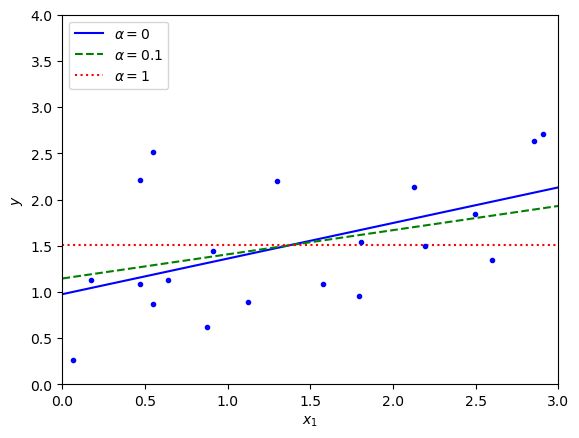

In [57]:
# 线性模型
plot_model(Regul=Lasso, polynomial=False, Rates=(0, 0.1, 1), random_state=42)

/home/sora/anaconda3/envs/DL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


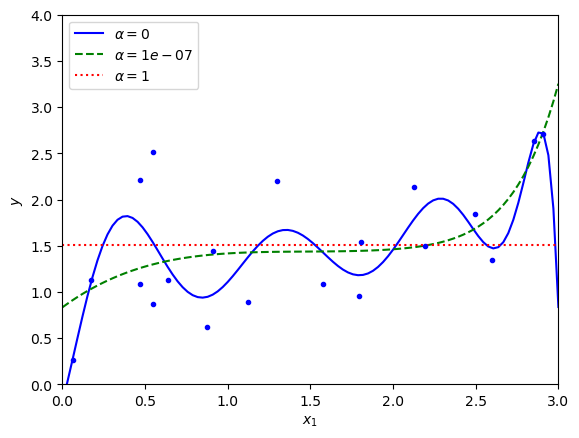

In [58]:
# 多项式模型
plot_model(Regul=Lasso, polynomial=True, Rates=(0, 10**-7, 1), random_state=42)

`Lasso回归` 最重要的一个特点是，它倾向于完全消除掉最不重要的特征的权重。如上图$\lambda=1e-07$看起来像是二次，接近于线性：因为所有的高阶多项式的特征权重都等于0

$ ℓ_1$,$ ℓ_2$两个正则化都会压缩系数$\boldsymbol{w}$的大小,对标签贡献更少的特征的系数会更小,也会更容易被压缩。不过,$ ℓ_2$正则化只会将系数压缩到尽量接近0,但$ ℓ_1$正则化主导稀疏性,因此会将系数压缩到0.

这个性质,让`Lasso`成为了线性模型中的`特征选择`工具首选.

存在警告 红条：目标函数没有收敛,你也许想要增加迭代次数,使用一个非常小的 alpha来拟合模型可能会造成精确度问题!
- 这是由于 `sklearn`中的`Lasso`类不是使用最小二乘法来进行求解, 而是使用坐标下降。
- 由于`Lasso`对正则化系数的变动过于敏感,因此往往让在很小的空间中变动。这个小空间小到超乎人们的想象,因此设定了一个重要概念`正则化路径`,用来设定正则化系数的变动.


<img src="../images/other/4-12.png" width="600">

>公式14：Lasso 子梯度向量 Lasso Regression subgradient vector 
$$
g(\boldsymbol{\theta}, J)=\nabla_{\boldsymbol{\theta}} \operatorname{MSE}(\boldsymbol{\theta})+\alpha\left(\begin{array}{c}
\operatorname{sign}\left(\theta_{1}\right) \\
\operatorname{sign}\left(\theta_{2}\right) \\
\vdots \\
\operatorname{sign}\left(\theta_{n}\right)
\end{array}\right) \quad \text { where } \operatorname{sign}\left(\theta_{i}\right)=\left\{\begin{array}{cc}
-1 & \text { if } \theta_{i}<0 \\
0 & \text { if } \theta_{i}=0 \\
+1 & \text { if } \theta_{i}>0
\end{array}\right.
$$

使用`梯度向量`$g$替代任何$\theta_i=0$,梯度下降可以正常工作。

## 弹性网络 Elastic Net

`弹性网络`是介于`岭回归`和`Lasso回归`之间的中间地带，正则项是岭和Lasso正则项的简单混合，你可以控制混合比$r$。

>公式15：弹性网络成本函数  Elastic Net cost function
$$
J\left( \theta  \right)= MSE(\theta)+r\alpha  \sum\limits_{i=1}^{n}{|\theta _{i}|}+\frac{1-r}{2} \alpha  \sum\limits_{i=1}^{n}{\theta _{i}^{2}}
$$

当$r=0$时，`弹性网络`等效于`岭回归`。当$r=1$时，`弹性网络`等效于`Lasso回归`

`Scikit-Learn`的`ElasticNet`实现`弹性网络`

In [59]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## 提前停止 Early Stopping

`提前停止法`:当验证集上的性能不再提高时停止训练集上学习的方法,旨在克服过拟合现象.

1. 首先随机生成线性数据集  **$y=2+0.5x+$高斯噪音**,并划分好训练集和测试集

In [60]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

2. `提前停止法`的基本实现,以高阶多项式回归模型为例

In [61]:
from copy import deepcopy

# 特征抽取 标准化
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

poly_scaler.fit(X_train, y)
X_train_poly_scaled = poly_scaler.transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)


# 随机梯度下降模型预估器
sgd_model = SGDRegressor(max_iter=1,        # 使用 批量梯度下降 
                         tol=-np.infty,     # -∞
                         warm_start=True,   # 调用fit()方法时，在前一阶段的训练结果上继续训练，而不是从头开始
                         penalty=None,    
                         learning_rate="constant",   # 使用eta0来指定学习率
                         eta0=0.0005,
                         random_state=42
                        )

# 初始化参数
minium_val_error = float("inf")
best_epoch = None
best_model = None
epochs = 1000

# 获取不同轮次下的预测误差,并记录最佳轮次,该轮次下的经过训练后模型,MSE
for epoch in range(epochs):
    sgd_model.fit(X_train_poly_scaled, y_train)       # 从停止的地方继续开始训练
    y_val_pred = sgd_model.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_true=y_val, y_pred=y_val_pred)
    
    if val_error < minium_val_error:
        minium_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_model)

In [62]:
minium_val_error, best_epoch 

(1.3513110512453865, 239)

3. 绘制图像 

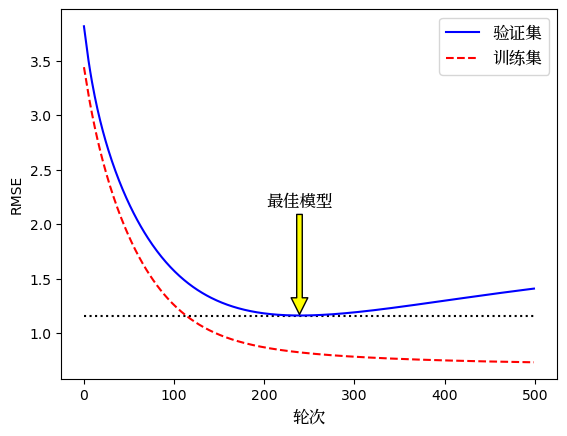

In [63]:
sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       warm_start=True,
                       penalty=None,
                       learning_rate="constant",
                       eta0=0.0005,
                       random_state=42)

epochs = 500
train_errors, val_errors = [], []
for epoch in range(epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)  # 取最小值的下标
best_val_rmse = np.sqrt(val_errors[best_epoch])

# plt.annotate用于标注文字
plt.annotate(
    text='最佳模型',
    xy=(best_epoch, best_val_rmse),  # 被注释的坐标点
    xytext=(best_epoch, best_val_rmse + 1),  # 注释文字的坐标位置
    ha="center",
    arrowprops=dict(facecolor='yellow', shrink=0.01),  # 箭头参数,参数类型为字典dict
    fontproperties=my_font)

plt.plot([0, epochs], [best_val_rmse, best_val_rmse], "k:")
plt.plot(np.sqrt(val_errors), "b-", label="验证集")
plt.plot(np.sqrt(train_errors), "r--", label="训练集")
plt.legend(loc="upper right", prop=my_font)
plt.xlabel("轮次", fontproperties=my_font)
plt.ylabel("RMSE")
plt.show()

# 逻辑回归 Logistic Regression

## 估计概率 Estimating Probabilities

不同于线性回归直接输出结果，逻辑回归输出的是数理逻辑值.
> 公式16:逻辑回归模型的估计概率(向量化形式) Logistic Regression model estimated probability (vectorized form)
$$
\hat{p}=h_{\boldsymbol{\theta}}(\mathbf{x})=\sigma\left(\mathbf{\theta}^{T} \boldsymbol{x}\right)
$$

> 公式17:逻辑函数 Logistic function
$$
\sigma(t)=\frac{1}{1+\exp (-t)}
$$

In [64]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

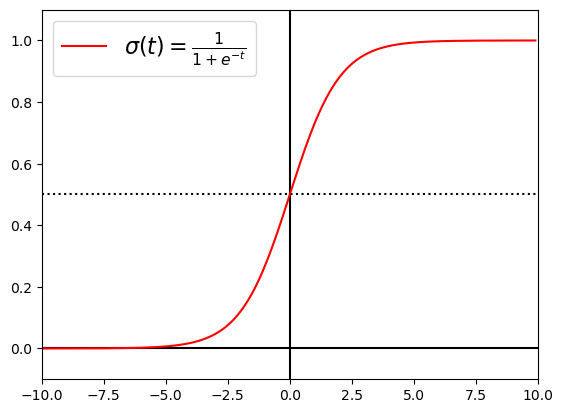

In [65]:
plt.plot([-10,10], [0,0], 'k-')
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([0,0], [-0.1,1.1], 'k-')
nums = np.arange(-10,10,step=0.1)
plt.plot(nums,sigmoid(nums),'r',label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.axis([-10, 10, -0.1, 1.1])
plt.legend(fontsize=16)
plt.show()

> 公式17:逻辑回归模型预测 Logistic Regression model prediction
$$
\hat{y}=\left\{\begin{array}{l}
0 \ ,\text  { if } \hat{p}<0.5 \\
1 \ ,\text { if } \hat{p} \geq 0.5
\end{array}\right.
$$

如果$x^T\theta$是正类，逻辑回归模型预测结果为1，如果为负类，则预测为0

## 训练和成本函数 Training and Cost Function

整个训练集的成本函数是所有训练实例的平均成本。可以用一个称为`对数损失`的单一表达式表示:
>公式18:逻辑回归成本函数(对数损失) Logistic Regression cost function (log loss):
$$
J\left( \theta  \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{\left[{{y}^{(i)}}\log \left( \hat{p}^{(i)}\right )+\left( 1-{{y}^{(i)}} \right)\log \left( 1- \hat{p}^{(i)}\right)\right]}
$$

该函数不存在闭式方程来计算最小换成本函数的θ，但由于是凸函数，所以可以通过梯度下降保证找到全局最小值。

>公式19:逻辑回归成本函数的导函数 Logistic cost function partial derivatives:
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{\left(\sigma\left(\mathbf{\theta}^{T} \boldsymbol{x^{(i)}}\right)-{{y}^{(i)}}\right)x_{_{j}}^{(i)}}$$

## 决策边界 Decision Boundaries

以鸢尾植物数据集来说明逻辑回归。这个数据集中共有150朵鸢尾花分别来自于不同的三个品种(山鸢尾，变色鸢尾和维吉尼亚鸢尾),数据中包含花的萼片以及花瓣的长度和宽度。

<img src="../images/other/4-14.png" width="400">

- 仅基于花瓣宽度这一个特征，创建一个分类器来检测维吉尼亚鸢尾。

1. 加载数据集

In [66]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [67]:
X = iris['data'][:, 3:]   # 花瓣宽度
y = (iris['target'] == 2).astype(np.int)   # 维吉尼亚鸢尾

/tmp/ipykernel_47976/2541421692.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris['target'] == 2).astype(np.int)   # 维吉尼亚鸢尾


2. 训练逻辑回归模型

`Scikit-Learn`的`LogisticRegression`实现逻辑回归

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
log_model = LogisticRegression(solver="lbfgs", random_state=42)  #  L-BFGS 
log_model.fit(X, y)

LogisticRegression(random_state=42)

默认是$ ℓ_2$正则,控制正则化程度的超参数不是alpha，而是c(正则化系数λ的倒数)，越小的数值表示越强的正则化。

3. 估计概率和决策边界

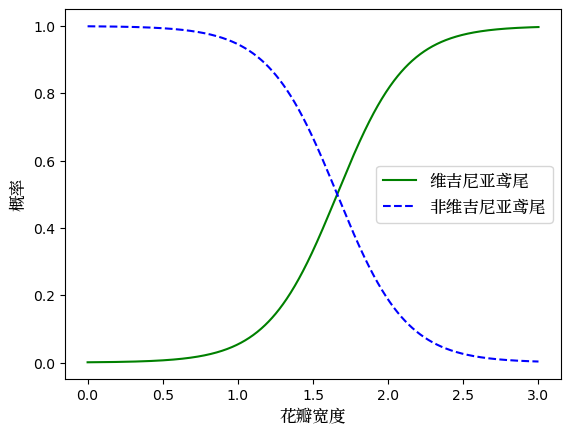

In [70]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  
y_proba = log_model.predict_proba(X_new)       # 预测样本为某个标签的概率

plt.plot(X_new, y_proba[:, 1], 'g-', label='维吉尼亚鸢尾')
plt.plot(X_new, y_proba[:, 0], 'b--', label='非维吉尼亚鸢尾')
plt.xlabel('花瓣宽度', fontproperties=my_font)
plt.ylabel('概率', fontproperties=my_font)
plt.legend(prop=my_font)
plt.show()

通过观察我们得知：维吉尼亚鸢尾的花瓣宽度范围为1.4\~2.5cm，而其他鸢尾品种相对较窄,为0.1\~1.8之间，注意存在一部分重叠。对于1\~2cm之间的花瓣宽度，分类器则不太有把握。

<img src="../images/other/4-15.png" width="600">

如果要求预测类别，即便没有什么把握分类器也会返回一个最大可能性的类别。

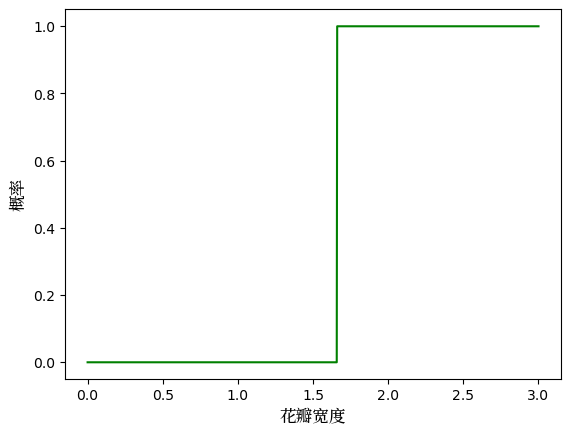

In [71]:
y_proba = log_model.predict(X_new)      

plt.plot(X_new, y_proba, 'g-')
plt.xlabel('花瓣宽度', fontproperties=my_font)
plt.ylabel('概率', fontproperties=my_font)
plt.show()

- 基于花瓣宽度和长度这两个特征，创建一个分类器来检测维吉尼亚鸢尾。

<img src="../images/other/4-16.png" width="600">

## Softmax回归 Softmax Regression

逻辑回归经过推广，可以直接支持多个类别，而无需训练并组合多个二元分类器。这就是`Softmax回归`(多元逻辑回归)

其原理为:对于给定实例$x$，Softmax模型首先计算出每个类别$k$的分数$s_k(x)$，然后对这些分数应用softmax函数（归一化指数），估算出每个类别的概率。
>公式20:类$k$的Softmax分数
$$s_k(x)=θ_k^Tx$$


计算出实例$x$每个类别的分数后，可以通过Softmax函数来估计实例属于类别$k$的概率${\hat{p}}^k$。

>公式21:Softmax函数公式
$${\hat{p}}_k=σ(s(x))_k=\frac{e^{s_k(x)}}{\sum\limits_{j=1}^{K}e^{(s_j(x))}}$$
其中:
- K是类别的数量
- $s(x)$是实例$x$每个类别的分数的向量
- $σ(s(x))_k$是给定的类别分数下，实例$x$属于类别k的概率。

就像逻辑回归分类器一样，Softmax回归分类器预测具有最高估计概率的类。$argmax$运算符返回使函数最大化的变量值。
Softmax回归分类器一次只能预测一个类，因此它只能与互斥的类一起使用。
>公式22:Softmax回归分类预测
$$
\hat{y}=\underset{k}{\operatorname{argmax}} \sigma(\mathbf{s}(\mathbf{x}))_{k}=\underset{k}{\operatorname{argmax}} s_{k}(\mathbf{x})=\underset{k}{\operatorname{argmax}}\left(\left(\boldsymbol{\theta}^{(k)}\right)^{T} \mathbf{x}\right)
$$

对于分类问题的损失函数来说，不适宜采用`MSE`，主要原因是逻辑回归配合`MSE`损失函数时，采用梯度下降法进行学习时，会出现模型一开始训练时，学习速率非常慢的情况。

对于这类问题，我们采用`交叉熵最小化`来实现对目标类做出高概率估算的模型的目标。交叉熵经常被用于衡量一组估算出的类概率跟目标类的匹配程度。

>公式23:交叉熵成本函数 Cross entropy cost function
$$
J(\boldsymbol{\Theta})=-\frac{1}{m} \sum\limits_{i=1}^{m} \sum_{k=1}^{K} y_{k}^{(i)} \log \left(\hat{p}_{k}^{(i)}\right)
$$
其中:
$y_{k}^{(i)}$  是属于$k$类的第$i$个实例的目标概率。一般而言，等于1或0，具体取决于实例是否属于这类。


当$K=2$时，此成本函数等效于逻辑回归的成本函数(公式18)

>公式24:类$k$的交叉熵梯度向量
$$
\nabla_{\boldsymbol{\theta}^{(k)}} J(\boldsymbol{\Theta})=\frac{1}{m} \sum_{i=1}^{m}\left(\hat{p}_{k}^{(i)}-y_{k}^{(i)}\right) x^{(i)}
$$

接下来，你可以计算每一个类的梯度向量，然后使用梯度下降算法来找到最小化成本函数的参数矩阵${\Theta}$。

- 基于花瓣宽度和长度这两个特征,使用`Softmax`回归,创建一个分类器将鸢尾花分成3类

In [72]:
X = iris['data'][:, (2,3)]   # 花瓣宽度和长度
y = iris['target']

In [73]:
from sklearn.linear_model import LogisticRegression
softmax_model = LogisticRegression(multi_class="multinomial",   
                                   solver="lbfgs",
                                   C=10
                                  )
softmax_model.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

- `multi_class`:从默认ovr一对多切换为Softmax回归
    - 如果选择了ovr，则4种损失函数的优化方法liblinear，newton-cg, lbfgs和sag都可以选择。
    - 如果选择了multinomial,则只能选择newton-cg, lbfgs和sag
- 默认使用L2正则化，通过超参数`C`进行控制

In [74]:
# 预测花瓣长度5cm,宽度2cm的鸢尾花品种
softmax_model.predict([[5, 2]]), softmax_model.predict_proba([[5, 2]])

(array([2]), array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]]))

经过预测，可知有94.2%概率为维吉尼亚鸢尾

- Softmax回归决策边界

<img src="../images/other/4-17.png" width="600">

# 练习题 Exercise

##  ex. 1

Q: 如果训练集具有数百万个特征,那么可以使用哪种线性回归训练算法?

>If you have a training set with millions of features you can use **Stochastic Gradient Descent** (随机梯度下降)or **Mini-batch Gradient Descent**(小批量梯度下降), and perhaps **Batch Gradient Descent** if the training set fits in memory(内存). But you cannot use the Normal Equation(标准方法) or the SVD approach because the computational complexity grows quickly(more than quadratically) with the number of features.

## ex. 2

Q:如果训练集里特征的数值大小迥异,哪种算法可能会受到影响?受影响程度如何?你应该怎么做?

>If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl(细长碗的形状), so the **Gradient Descent algorithms will take a long time to converge(收敛)**.

>To solve this you should **scale(缩放) the data before training the model**. 

>Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution(次优解) if the features are not scaled: since regularization penalizes(惩罚) large weights, features with smaller values will tend to be ignored compared to features with larger values.

## ex. 3

Q:训练逻辑回归模型时,梯度下降会卡在局部最小值中吗?

>Gradient Descent **cannot get stuck in a local minimum** when training a Logistic Regression model because the cost function is convex(凸函数).

## ex. 4

Q:如果你让它们运行足够长的时间,是否所有的梯度下降算法都能得出相同的模型?

>If the optimization problem is **convex** (such as Linear Regression or Logistic Regression), and **assuming the learning rate is not too high**, then all Gradient Descent algorithms will approach the global optimum(全局最优) and end up **producing fairly similar models**. 

>However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD **will never truly converge**; instead, they will keep jumping back(来回跳跃) and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce **slightly different models**.

## ex. 5

Q:假设你使用批量梯度下降,并在每个轮次绘制验证误差。如果你发现验证错误持续上升,可能是什么情况?你该如何解决?

> If the validation error(验证误差) consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging(发散). If the **training error(训练误差) also goes up**, then this is clearly the problem and you should **reduce the learning rate**. 

>However, if the **training error is not going up**, then your model is **overfitting** the training set and you should **stop training**.

## ex. 6

Q:当验证错误上升时立即停止小批量梯度下降是个好主意吗?

>Due to their random nature(随机性), neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed (保证)to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you **may stop much too early, before the optimum is reached**. 

>A better option is to save the model at regular intervals(一定时间间隔); then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert(恢复) to the best saved model.

## ex. 7

Q:哪种梯度下降算法(在我们讨论过的算法中)将最快到达最佳解附近?哪个实际上会收敛，如何使其他的也收敛？

>**Stochastic Gradient Descent** has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only **Batch Gradient Descent** will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce(反弹) around the optimum, unless you **gradually reduce the learning rate**.

## ex. 8

Q:假设你正在使用多项式回归。绘制学习曲线后,你会发现训练误差和验证误差之间存在很大的差距。发生了什么?解决此问题的三种方法是什么?

>If the validation error is much higher than the training error, this is likely because
 your **model is overfitting(过拟合) the training set**. 
 1. One way to try to fix this is to **reduce the polynomial degree**: a model with fewer degrees of freedom is less likely to overfit. 
 2. Another thing you can try is to **regularize the model**—for example, by adding an$ ℓ 2$penalty (Ridge) or an $ℓ 1$penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. 
 3. Lastly, you can try to **increase the size of the training set**.

## ex. 9

Q: 假设你正在使用岭回归，并且你注意到训练误差和验证误差几乎相等且相当高。你是否会说模型存在高偏差或者是高方差？你应该增加正则化超参数$\alpha$还是减少它呢？

>If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting(欠拟合) the training set, which means it has a **high bias(高偏差)**. You should try **reducing** the regularization hyperparameter α.

## ex. 10

Q:为什么要使用:
1. 岭回归而不是简单的线性回归(即没有任何正则化)?
2. Lasso 而不是岭回归?
3. 弹性网络而不是 Lasso?

>- A model with some regularization typically performs **better** than a model without any regularization, so you should **generally prefer Ridge Regression** over plain Linear Regression.
- Lasso Regression uses an $ℓ 1$ penalty, which tends to **push the weights down to exactly zero**. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform **feature selection automatically**, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
- Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when **several features are strongly correlated** or when there are **more features than training instances**). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.

## ex. 11

Q:假设你要将图片分类为室外/室内和白天/夜间。你应该实现两个逻辑回归分类器还是一个 Softmax 回归分类器?

> If you want to classify pictures as outdoor/indoor and daytime/nighttime, since
 these are not exclusive classes (i.e., all four combinations are possible) you should
 train two **Logistic Regression classifiers**.

## ex. 12 

Q: Implement Batch Gradient Descent with early stopping for Softmax Regression
 (without using Scikit-Learn).
 
 用`Softmax`回归进行BGD训练，实现提前停止法(不使用`Scikit-Learn`)

In [75]:
from sklearn import datasets

np.random.seed(2042)

1. 加载数据集

In [76]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [77]:
X = iris['data'][:, (2,3)]   # 花瓣宽度和长度
y = iris['target']

In [78]:
# 添加偏置项 x_0=1
X = np.c_[np.ones([len(X), 1]), X]
X[:5]

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2]])

2. 分割数据集

In [79]:
# 测试集和验证集的比例
test_ratio = 0.2
val_ratio = 0.2

# 训练集，测试集和验证集的数据量
total_size = len(X)
test_size = int(total_size * test_ratio)
val_size = int(total_size * val_ratio)
train_size  = total_size - test_size - val_size

In [80]:
random_index = np.random.permutation(total_size)

In [81]:
X_train = X[random_index[:train_size]]
y_train = y[random_index[:train_size]]

X_val = X[random_index[train_size:-test_size]]
y_val = y[random_index[train_size:-test_size]]

X_test = X[random_index[-test_size:]]
y_test = y[random_index[-test_size:]]

In [82]:
X_train.shape, X_val.shape, X_test.shape

((90, 3), (30, 3), (30, 3))

3. one-hot数据预处理

In [83]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [84]:
y_train[:5]

array([0, 1, 2, 1, 1])

In [85]:
to_one_hot(y_train[:5])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [86]:
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_val)
y_test_one_hot = to_one_hot(y_test)

4. 定义输入和输出大小

In [87]:
inputs = X_train.shape[1]          # 3 (两个特征+偏置项)
outputs = len(np.unique(y_train))  # 3 (山鸢尾，变色鸢尾和维吉尼亚鸢尾)

5. 实现Softmax函数

对于给定实例$x$，Softmax模型首先计算出每个类别$k$的分数$s_k(x)$，然后对这些分数应用softmax函数（归一化指数），估算出每个类别的概率。
>公式21:Softmax函数公式
$$\hat{p}_{k}^{(i)}=\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$$

In [88]:
def softmax(logits):  # logits 未归一化的分数
    exps = np.exp(logits)
    exps_sum = np.sum(exps, axis=1, keepdims=True)  # 保持矩阵的形状
    return exps / exps_sum

6. 训练Softmax模型

>公式23:交叉熵成本函数 Cross entropy cost function
$$
J(\boldsymbol{\Theta})=-\frac{1}{m} \sum\limits_{i=1}^{m} \sum_{k=1}^{K} y_{k}^{(i)} \log \left(\hat{p}_{k}^{(i)}\right)
$$
其中:
$y_{k}^{(i)}$  是属于$k$类的第$i$个实例的目标概率。一般而言，等于1或0，具体取决于实例是否属于这类。

>公式24:类$k$的交叉熵梯度向量
$$
\nabla_{\boldsymbol{\theta}^{(k)}} J(\boldsymbol{\Theta})=\frac{1}{m} \sum_{i=1}^{m}\left(\hat{p}_{k}^{(i)}-y_{k}^{(i)}\right) x^{(i)}
$$

>公式8：梯度下降步骤Gradient Descent step 
$$
\theta^{{(k)}{(next\ step)}}:=\theta^{(k)}−η\nabla_{\boldsymbol{\theta}^{(k)}} J(\boldsymbol{\Theta})\\
$$

In [89]:
Rate = 0.01        # 学习率
iterations = 5001  # 迭代次数
m = len(X_train)  

espsilon = 1e-7    
# 用于函数np.log计算的附加参数，保证不计算0的自然底数的对数

In [90]:
theta = np.random.randn(inputs, outputs)  # 初始θ 生成3*3的随机矩阵

In [91]:
for i in range(iterations):
    logits = X_train@theta
    y_proba = softmax(logits)  # 各类别的概率
    
    
    if i % 500 == 0:
        # 交叉熵成本函数
        loss = -np.mean(np.sum(y_train_one_hot * np.log(y_proba+espsilon), axis=1))
        print(i, loss)
    
    # 计算偏差
    error = y_proba - y_train_one_hot   # (900,3)
    
    # 交叉熵梯度向量
    gradients = (1/m) * (X_train.T @ error)  # (3,3)
    
    # 梯度下降
    theta = theta - Rate * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


In [92]:
theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

7. 利用验证集进行预测并评估

>公式22:Softmax回归分类预测
$$
\hat{y}=\underset{k}{\operatorname{argmax}} \sigma(\mathbf{s}(\mathbf{x}))_{k}=\underset{k}{\operatorname{argmax}} s_{k}(\mathbf{x})=\underset{k}{\operatorname{argmax}}\left(\left(\boldsymbol{\theta}^{(k)}\right)^{T} \mathbf{x}\right)
$$

In [93]:
logits = X_val@theta
y_proba = softmax(logits)
y_pred = np.argmax(y_proba, axis=1)
y_pred

array([0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1,
       2, 2, 1, 0, 0, 1, 1, 1])

In [94]:
from sklearn.metrics import classification_report   #这个包是评价报告
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.92      0.96        12
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



8. 添加$\ell_2$正则化惩罚项

>公式9：岭回归成本函数  Ridge Regression cost function
$$
J\left( \theta  \right)= MSE(\theta)+ \alpha  \sum\limits_{i=1}^{n}{\theta _{i}^{2}}
$$

In [95]:
Rate = 0.1        
iterations = 5001  
m = len(X_train)  
espsilon = 1e-7    

alpha = 0.1       # 正则化系数 𝛼

In [96]:
theta = np.random.randn(inputs, outputs)  # 初始θ 生成3*3的随机矩阵

In [97]:
for i in range(iterations):
    logits = X_train@theta
    y_proba = softmax(logits)  # 各类别的概率
    
    
    if i % 500 == 0:
        # 交叉熵成本函数
        cost = -np.mean(np.sum(y_train_one_hot * np.log(y_proba+espsilon), axis=1))
        reg = 1/2 * np.sum(np.square(theta[1:]))
        costReg = cost + alpha * reg
        print(i, costReg)
    
    # 计算偏差
    error = y_proba - y_train_one_hot   # (900,3)
    
    # L2正则化交叉熵梯度向量
    gradients_reg = np.r_[np.zeros([1, outputs]), alpha * theta[1:]]
    gradients = (1/m) * X_train.T @ error  + gradients_reg

    # 梯度下降
    theta = theta - Rate * gradients

0 6.629842469083912
500 0.5339667976629506
1000 0.503640075014894
1500 0.4946891059460321
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.48929905984511984
3500 0.4890351244397859
4000 0.4889173621830818
4500 0.4888643337449302
5000 0.4888403120738818


由于添加$\ell_2$正则化惩罚项，损失会大于前例所示不添加.

In [98]:
theta

array([[ 4.97985231,  1.04812068, -4.23604635],
       [-1.09769275,  0.12541575,  0.972277  ],
       [-0.43733964, -0.13642992,  0.57376956]])

9. 利用验证集进行预测并评估(添加$\ell_2$正则化的模型)

In [99]:
logits = X_val@theta
y_proba = softmax(logits)
y_pred = np.argmax(y_proba, axis=1)
y_pred

array([0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1,
       2, 2, 1, 0, 0, 1, 1, 2])

In [100]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



10. 实现提前停止法

    当验证集上的性能不再提高时停止训练集上学习的方法,旨在克服过拟合现象.

In [101]:
Rate = 0.1        
iterations = 5001  
m = len(X_train)  
espsilon = 1e-7    

alpha = 0.1       # 正则化系数 𝛼

In [102]:
np.random.seed(2042)
theta = np.random.randn(inputs, outputs)  # 初始θ 生成3*3的随机矩阵

In [103]:
minium_val_error = np.infty
best_epoch = None
theta_list = []

In [104]:
for i in range(iterations):
    # 训练集
    train_logits = X_train@theta
    y_train_proba = softmax(train_logits) 
    train_error = y_train_proba - y_train_one_hot
    train_gradients_reg = np.r_[np.zeros([1, outputs]), alpha * theta[1:]]
    train_gradients = (1/m) * X_train.T @ train_error + train_gradients_reg
    theta = theta - Rate * train_gradients
    theta_list.append(theta)
    
    # 验证集
    val_logits = X_val@theta
    y_val_proba = softmax(val_logits)
    
    # 验证集的交叉熵成本函数
    val_cost = -np.mean(np.sum(y_valid_one_hot * np.log(y_val_proba+espsilon), axis=1))
    reg = 1/2 * np.sum(np.square(theta[1:]))
    val_costReg = val_cost + alpha * reg
    
    if i % 500 == 0:
        print(i, val_costReg)
        
    # 实现提前停止
    if val_costReg < minium_val_error:
        minium_val_error = val_costReg
        best_epoch = i
    else:
        print(best_epoch, minium_val_error)
        print(i, val_costReg, "->提前停止")
        break

0 2.0392966561323487
500 0.5712186106706888
1000 0.5427543296320803
1500 0.5353671267222123
2000 0.5331424065221559
2500 0.5325854810303734
2743 0.5325453999385228
2744 0.5325453999685446 ->提前停止


<img src="../images/other/4-18.png" width="400">

11. 利用验证集进行预测并评估(提前停止法)

In [105]:
logits = X_val@theta_list[-2]
y_proba = softmax(logits)
y_pred = np.argmax(y_proba, axis=1)
y_pred

array([0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1,
       2, 2, 1, 0, 0, 1, 1, 2])

In [106]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



12. Softmax回归决策边界

<img src="../images/other/4-19.png" width="600">

> create:Apotosome 

> update:Apotosome 10/25/22